In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import GCRCatalogs
from clmm import ShearAzimuthalAverager

### Read in the extragalactic catalog
- identify the most massive halo
- create a cluster dictionary (ra, dec, z)

In [2]:
extragalactic_cat = GCRCatalogs.load_catalog('proto-dc2_v2.1.2_test')

# get a massive halo!
massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec'],\
                                                 filters=['halo_mass > 1e14','is_central==True'])

m = massive_halos['halo_mass']
select = (m == np.max(m))
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
print(m[select], ra_cl, dec_cl, z_cl)

# make a dictionary for cluster
cl_dict = {'z':z_cl, 'ra':ra_cl, 'dec': dec_cl}


/global/homes/m/mho1/.local/lib/python3.6/site-packages/GCRCatalogs/alphaq.py:105: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')


[  5.95588752e+14] 1.15419 2.20399 0.354081722946


### Apply coordinates and redshift cuts to select backgroud galaxies around the cluster

In [3]:
# get galaxies around it
ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
z_min = z_cl + 0.1
z_max = 1.5

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]
z_filters = ['redshift >= {}'.format(z_min),'redshift < {}'.format(z_max)]

gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2', 'shear_2_phosim', 'shear_2_treecorr',\
                                            'redshift', 'convergence'], filters=(coord_filters + z_filters))

# store the results into an astropy table
t = Table([gal_cat['galaxy_id'],gal_cat['ra'],gal_cat['dec'],gal_cat['shear_1'],\
          gal_cat['shear_2'],gal_cat['redshift'],gal_cat['convergence']], \
          names=('id','ra','dec', 'gamma1', 'gamma2', 'z', 'kappa'))


### Computes the tangential and cross shear profiles

#### Default binning

/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/astropy/table/row.py:65: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


read g1, g2 directly


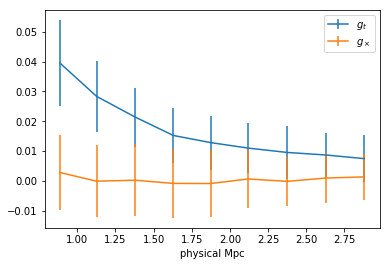

In [4]:
# create an object, given cluster dictionary and galaxy astropy table
saa = ShearAzimuthalAverager(cl_dict,t)

# compute tangential and cross shear for each galaxy
saa.compute_shear()

# make the binned profile
binned_profile = saa.make_shear_profile()

saa.plot_profile()   

#### User-defined binning

In [5]:
bins = [0., 0.2, 0.5, 0.7, 1.1]
binned_profile2 = saa.make_shear_profile(bins=bins)
binned_profile2

radius,ang_separation,g_t,g_x,g_t_err,g_x_err
Mpc,rad,,,,
float64,float64,float64,float64,float64,float64
0.14397379756,0.000140245712828,0.0116230389103,-0.000505482079461,0.0113873202354,0.0100326472893
0.384573996067,0.000374615745386,0.0374312028289,-0.00163857394364,0.0147435264662,0.0121505800635
0.610790014267,0.000594974146225,0.0427249409258,-0.00664938986301,0.0109946569428,0.0122991204262
0.923779428005,0.000899858947378,0.0375277325511,0.00194689736236,0.0141571117565,0.0127463107929


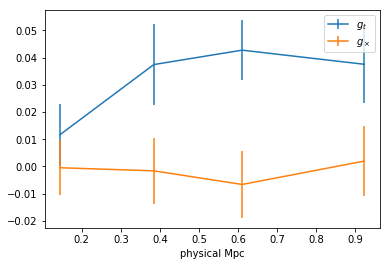

In [6]:
saa.plot_profile()